# Performance Analaysis of HEP codes (examples)

Authors: Brain Gravelle (gravelle@cs.uoregon.edu), Boyana Norris (norris@cs.uoregon.edu)


## 1. Prerequisites

These examples are based on the TAU and taucmdr tools from Paratools
http://taucommander.paratools.com/. Note that the analysis functionality is new and not yet publically available.

In [39]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

## 2. Performance data 

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

Available experiments:
* multi - data based on a toy version of the program.
* realistic  - data based on a run of the program with the TT35PU... input file, 10 threads, and 100 events
* event_scaling_TT35  - data based on a run of the program with the TT35PU... input file, 10 threads, and events ranging from 10 to 100
* TT70  - data based on a run of the program with the TT70PU... input file, 10 threads, and 100 events
* event_scaling_TT35  - data based on a run of the program with the TT70PU... input file, 10 threads, and events ranging from 10 to 100
* note that the event scaling runs don't have a function to properly load the data yet

### Simple explorations

First, let's load the data from the current directory (in a .tau subdirectory created by TAU Commander). We also print the metadata for the performance experiment, which contains details about the execution environment.

In [2]:
expr_intervals = load_perf_data(application="mictest_sampling",experiment="TTbar70_cache",nolibs=True)

#level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
print(expr_intervals.keys())
print("\nColumns:\n")
print(expr_intervals['PAPI_TOT_CYC'].columns)
print("\nNames:\n")
print(expr_intervals['PAPI_TOT_CYC'].index.names)
print("\nMetadata:\n")
print_metadata(expr_intervals)

['PAPI_BR_INS', 'PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD', 'PAPI_L2_TCA', 'PAPI_NATIVE_LLC_MISSES', 'PAPI_RES_STL', 'PAPI_L2_TCM', 'PAPI_TOT_INS', 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD', 'METADATA', 'PAPI_LST_INS', 'PAPI_BR_CN', 'PAPI_BR_UCN', 'PAPI_L1_TCM', 'PAPI_BR_MSP', 'PAPI_TOT_CYC', 'PAPI_NATIVE_LLC_REFERENCES']

Columns:

Index([u'Calls', u'Subcalls', u'Exclusive', u'Inclusive', u'ProfileCalls'], dtype='object')

Names:

[u'rank', u'context', u'thread', u'region']

Metadata:

TAU_MAX_THREADS                                    512
TAU_CUDA_BINARY_EXE                                None
TAU_MEASURE_TAU                                    off
Memory Size                                        98855488 kB
TAU_TRACK_SIGNALS                                  off
TAU_TRACK_IO_PARAMS                                off
CPU MHz                                            973.864
Local Time                                         2018-02-20T20:25:31-08:00
CPU Type                                

Next, let's look at inclusive measurements of a hardware performance counter, e.g., PAPI_TOT_INS, sorted in decreasing order. As you can see, there are separate entries for each thread.

In [40]:
thread_cycles = filter_libs_out(expr_intervals['PAPI_TOT_CYC']).sort_values(by='Inclusive',ascending=False)[["Inclusive"]]
thread_cycles.head(100)

Inclusive
rank context thread region                                                                            
0    0       0      [SUMMARY] Event::clean_cms_seedtracks()                                 4590945438
                    [SUMMARY] _int_free                                                     2578157027
                    [SUMMARY] _int_malloc                                                   2493065090
                    [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           2416012201
                    [SUMMARY] __svml_sincosf8_l9                                            2132547303
                    [SUMMARY] __GI___libc_malloc                                            2073114673
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1827178243
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1743074534
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1637751035
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1632943294
             2      [SUMMARY] __svml_sincosf8_l9                                            1560581652
             6      [SUMMARY] __svml_sincosf8_l9                                            1466274059
             0      [SUMMARY] __intel_mic_avx512f_memset                                    1441617163
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1404868079
             0      [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_201...  1396141344
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1388499936
                    [SUMMARY] __svml_sincosf8_l9                                            1388242596
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1361287994
             5      [SUMMARY] __svml_sincosf8_l9                                            1316291061
             8      [SUMMARY] __svml_sincosf8_l9                                            1290814771
             1      [SUMMARY] __svml_sincosf8_l9                                            1289543310
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1282037677
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)           1212025418
             9      [SUMMARY] __svml_sincosf8_l9                                            1121237806
             7      [SUMMARY] __svml_sincosf8_l9                                            1093078214
             5      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...  1051668071
             3      [SUMMARY] __svml_sincosf8_l9                                            1007729222
             0      [SUMMARY] __GI___sched_yield                                             951316750
             7      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...   939469788
             3      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...   921120361
             6      [SUMMARY] __intel_mic_avx512f_memset                                     841496138
             2      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...   819459421
             4      [SUMMARY] __intel_mic_avx512f_memset                                     806886107
             0      [SUMMARY] malloc_consolidate                                             783112946
                    [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...   777676002
             4      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, C...   750897505
             3      [SUMMARY] __intel_mic_avx512f_memset                                     742860359
             6      [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHit

Now let us compute mean values for each function (considering all threads). This functionality is also available in utilities, so the same can be computed with `cycles = means(thread_cycles,inclusive=True, plot=True)` (the last two arguments are optional).

In [4]:
cycles = thread_cycles.groupby('region')['Inclusive'].sum().reset_index()
mean_cycles = cycles.groupby('region').mean().sort_values(by='Inclusive',ascending=False)
mean_cycles.head(100)

,Inclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",15905678411
[SUMMARY] __svml_sincosf8_l9,13666339994
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",8092074825
[SUMMARY] __intel_mic_avx512f_memset,7679673888
"[SUMMARY] FMA(__m256 const&, __m256 const&, __m256 const&)",5528262878
[SUMMARY] Event::clean_cms_seedtracks(),4590945438
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",3968016925
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",3098876162
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyOut(int, float*) const",2805551193


To show these values as percentages, we can scale by the total cycles.

In [32]:
percent_cycles = pd.DataFrame(mean_cycles['Inclusive']/thread_cycles['Inclusive'].sum())
percent_cycles.reset_index()
percent_cycles.style.format({'Inclusive': '{:,.2%}'.format})

,Inclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",12.73%
[SUMMARY] __svml_sincosf8_l9,10.94%
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",6.48%
[SUMMARY] __intel_mic_avx512f_memset,6.15%
"[SUMMARY] FMA(__m256 const&, __m256 const&, __m256 const&)",4.42%
[SUMMARY] Event::clean_cms_seedtracks(),3.67%
"[SUMMARY] helixAtZ(Matriplex::Matriplex const&, Matriplex::Matriplex const&, Matriplex::Matriplex&, Matriplex::Matriplex const&, Matriplex::Matriplex&, int, bool)",3.18%
"[SUMMARY] Matriplex::MatriplexSym::CopyIn(int, float const*)",2.48%
"[SUMMARY] Matriplex::MatriplexSym::CopyOut(int, float*) const",2.25%


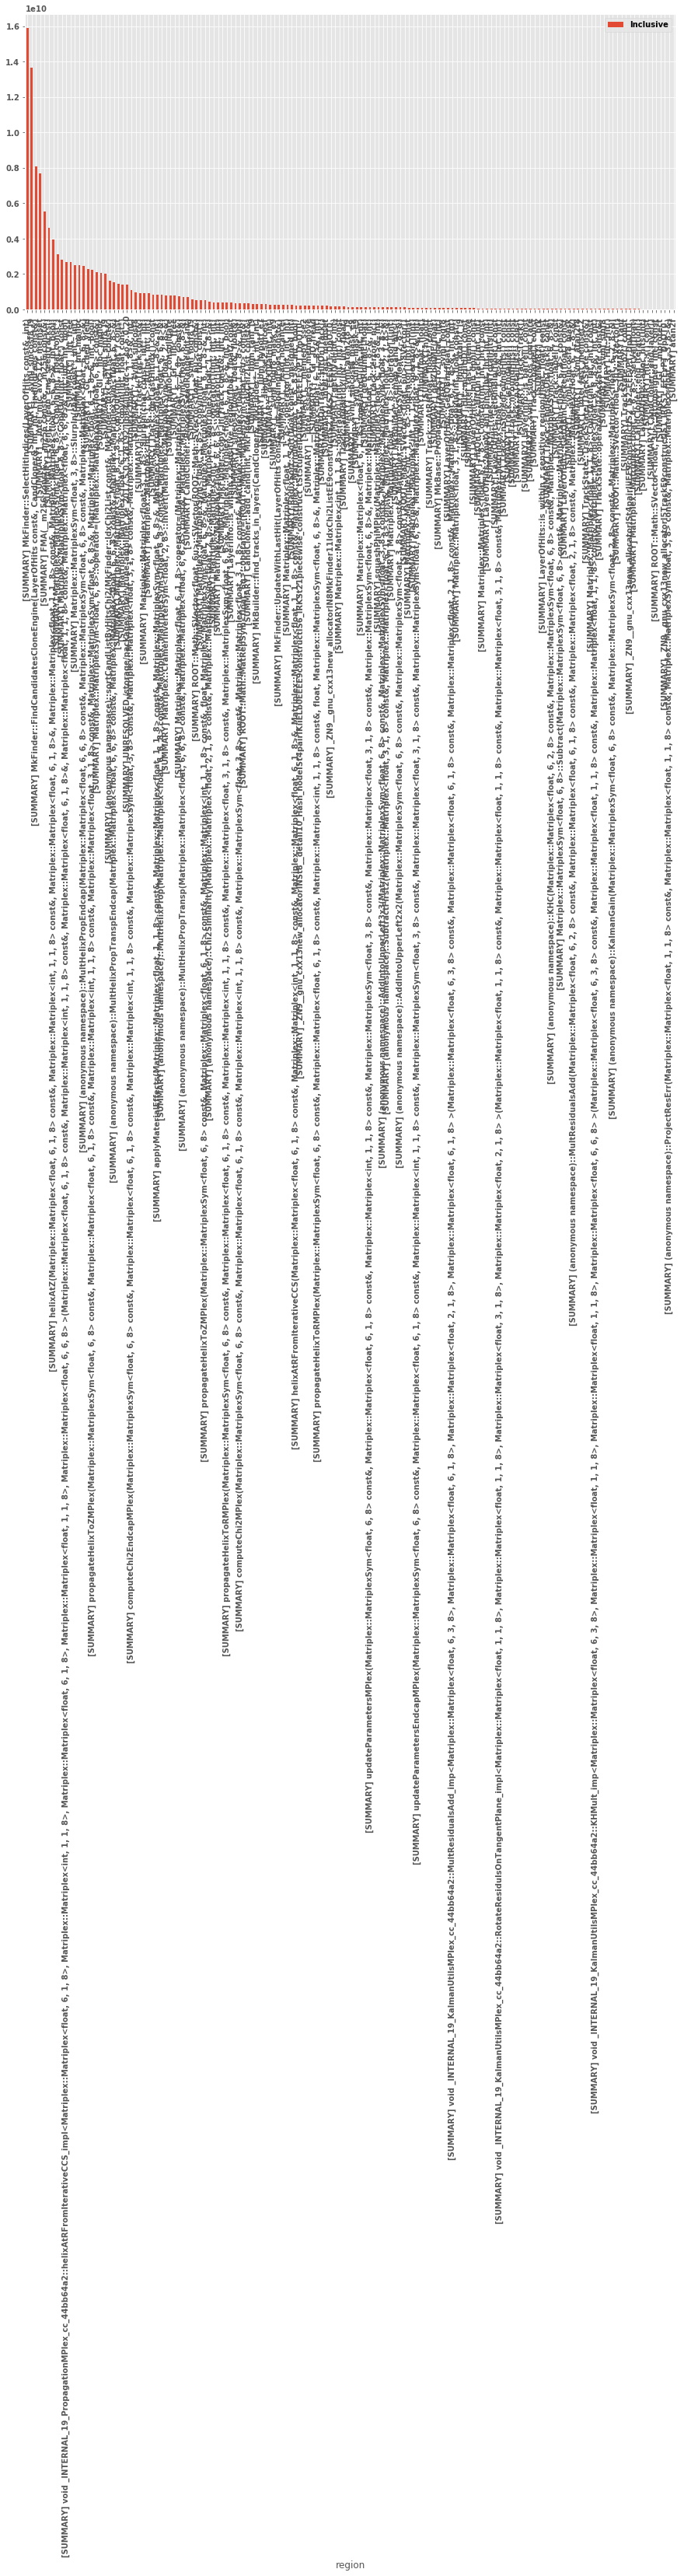

In [6]:
set_chart_font_size(10)
mean_cycles2 = means(thread_cycles,inclusive=True,plot=True)

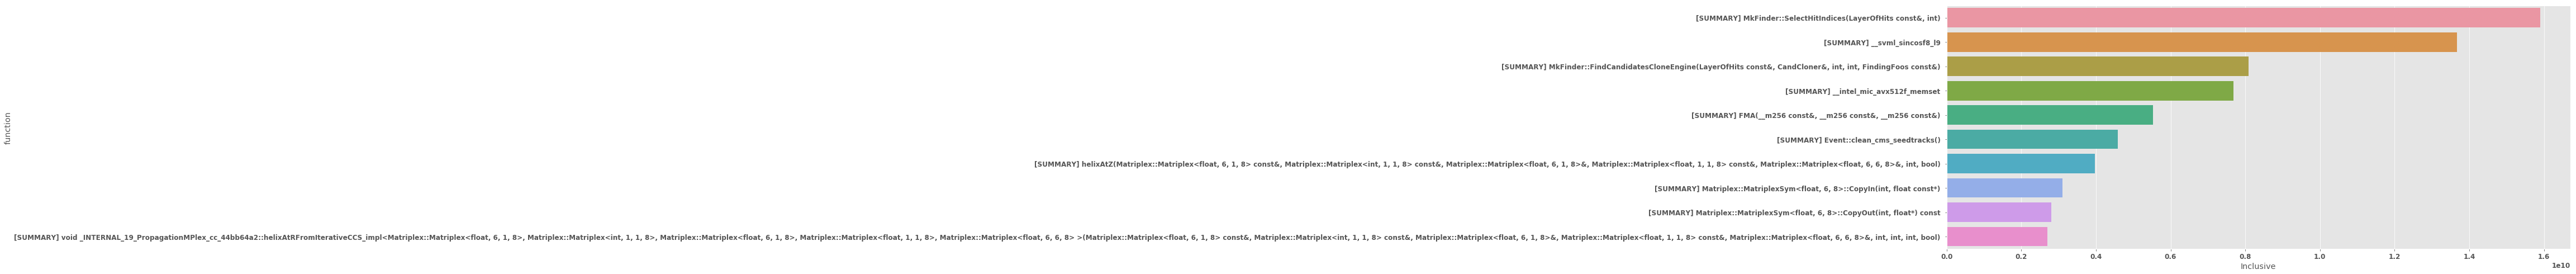

In [7]:
set_chart_font_size(12); plt.rcParams['figure.figsize']=(20,8)
mean_cycles2['function'] = mean_cycles2.index
g = sns.barplot(y='function',x='Inclusive',data=mean_cycles2.head(10))

### Another way to visualize function data

This is way too crowded, let's just look at the top functions. [Seaborn](https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/) is great for making dataframe visualizations. Let's look at the top 10 functions in terms of mean cycles per thread.

### Standard deviations

Next we look at the standard deviations in thread cycle counts.

In [37]:
# First, all threads
all_cycles = expr_intervals['PAPI_TOT_CYC'].groupby(['thread','region'])['Inclusive'].sum().reset_index()
pd.set_option('max_colwidth', 100)
all_cycles

,thread,region,Inclusive
0,0,"[SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriplex<float, 2, 1, 8> const&, Mat...",145368452
1,0,"[SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex<float, 6, 6, 8> const&, Matr...",95640114
2,0,"[SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Matriplex<float, 6, 6, 8> const&...",96860465
3,0,"[SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriplex::Matriplex<float, 6, 6, 8> ...",192705197
4,0,"[SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriplex<float, 3, 1, 8> const&, Mat...",48234535
5,0,"[SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::IdxChi2List const&, MkFinder::...",144803109
6,0,"[SUMMARY] CandCloner::ProcessSeedRange(int, int)",96984641
7,0,"[SUMMARY] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)",47358567
8,0,[SUMMARY] Event::clean_cms_seedtracks(),4590945438
9,0,"[SUMMARY] FMA(__m256 const&, __m256 const&, __m256 const&)",533212921


Thread 0 is clearly doing a lot of work that the others don't (to be expected with TBB), so it's more productive to focus on the remaining 9 threads. Per-thread cycle counts can then be obtained with:

In [9]:
all_cycles = all_cycles[all_cycles.thread != 0]  # exclude thread 0
all_cycles.groupby('thread').sum()

,Inclusive
thread,
1,10815190303
2,10643697870
3,10160276930
4,10727977065
5,10346425806
6,10225056099
7,10558971299
8,10435493924
9,9517649055


In [10]:
cycles_per_thread = all_cycles.groupby('thread').sum()
print(cycles_per_thread.head(10))
cycles_std = cycles_per_thread['Inclusive'].std()
print("Standard deviation over threads: %g"%cycles_std)

          Inclusive
thread             
1       10815190303
2       10643697870
3       10160276930
4       10727977065
5       10346425806
6       10225056099
7       10558971299
8       10435493924
9        9517649055
Standard deviation over threads: 3.92456e+08


So what is thread 0 doing that the others are not? Let's take a look:

In [11]:
thread_0 = expr_intervals['PAPI_TOT_CYC'].xs(0, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_0.head(20)

Calls  \
rank context region                                                      
0    0       [SUMMARY] Event::clean_cms_seedtracks()               101   
             [SUMMARY] _int_free                                    53   
             [SUMMARY] _int_malloc                                  54   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     50   
             [SUMMARY] __svml_sincosf8_l9                           44   
             [SUMMARY] __GI___libc_malloc                           45   
             [SUMMARY] __intel_mic_avx512f_memset                   30   
             [SUMMARY] UNRESOLVED /storage/packages/intel/vt...     30   
             [SUMMARY] __GI___sched_yield                           23   
             [SUMMARY] malloc_consolidate                           16   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...     16   
             [SUMMARY] __GI___libc_free                             14   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...     11   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...     10   
             [SUMMARY] __libm_tanf_l9                                7   
             [SUMMARY] __libm_hypotf_e7                              6   
             [SUMMARY] __libm_sse2_sincosf                           6   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      6   
             [SUMMARY] Matriplex::CramerInverterSym<float, 2...      6   
             [SUMMARY] __read_nocancel                               6   

                                                                 Subcalls  \
rank context region                                                         
0    0       [SUMMARY] Event::clean_cms_seedtracks()                    0   
             [SUMMARY] _int_free                                        0   
             [SUMMARY] _int_malloc                                      0   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             [SUMMARY] __svml_sincosf8_l9                               0   
             [SUMMARY] __GI___libc_malloc                               0   
             [SUMMARY] __intel_mic_avx512f_memset                       0   
             [SUMMARY] UNRESOLVED /storage/packages/intel/vt...         0   
             [SUMMARY] __GI___sched_yield                               0   
             [SUMMARY] malloc_consolidate                               0   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...         0   
             [SUMMARY] __GI___libc_free                                 0   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...         0   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...         0   
             [SUMMARY] __libm_tanf_l9                                   0   
             [SUMMARY] __libm_hypotf_e7                                 0   
             [SUMMARY] __libm_sse2_sincosf                              0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] Matriplex::CramerInverterSym<float, 2...         0   
             [SUMMARY] __read_nocancel                                  0   

                                                                  Exclusive  \
rank context region                                                           
0    0       [SUMMARY] Event::clean_cms_seedtracks()             4590945438   
             [SUMMARY] _int_free                                 2578157027   
             [SUMMARY] _int_malloc                               2493065090   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2416012201   
             [SUMMARY] __svml_sincosf8_l9                        2132547303   
             [SUMMARY] __GI___libc_malloc                        2073114673   
             [SUMMARY] __intel_mic_avx512f_memset                1441617163   
             [SUMMARY] UNRESOL

In [12]:
thread_1 = expr_intervals['PAPI_TOT_CYC'].xs(1, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_1.head(20)

Calls  \
rank context region                                                      
0    0       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     41   
             [SUMMARY] __svml_sincosf8_l9                           31   
             [SUMMARY] __intel_mic_avx512f_memset                   17   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...     17   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...     15   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...     11   
             [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...     10   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...     11   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...      8   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...     10   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      7   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      5   
             [SUMMARY] __GI___sched_yield                            7   
             [SUMMARY] Matriplex::Matriplex<int, 16, 1, 8>::...      6   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      5   
             [SUMMARY] (anonymous namespace)::MultHelixProp(...      5   
             [SUMMARY] __svml_sinf8_l9                               4   
             [SUMMARY] __svml_sincosf8                               4   
             [SUMMARY] computeChi2EndcapMPlex(Matriplex::Mat...      3   
             [SUMMARY] computeChi2MPlex(Matriplex::Matriplex...      3   

                                                                 Subcalls  \
rank context region                                                         
0    0       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             [SUMMARY] __svml_sincosf8_l9                               0   
             [SUMMARY] __intel_mic_avx512f_memset                       0   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...         0   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...         0   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...         0   
             [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...         0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...         0   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...         0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] __GI___sched_yield                               0   
             [SUMMARY] Matriplex::Matriplex<int, 16, 1, 8>::...         0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   
             [SUMMARY] (anonymous namespace)::MultHelixProp(...         0   
             [SUMMARY] __svml_sinf8_l9                                  0   
             [SUMMARY] __svml_sincosf8                                  0   
             [SUMMARY] computeChi2EndcapMPlex(Matriplex::Mat...         0   
             [SUMMARY] computeChi2MPlex(Matriplex::Matriplex...         0   

                                                                  Exclusive  \
rank context region                                                           
0    0       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1637751035   
             [SUMMARY] __svml_sincosf8_l9                        1289543310   
             [SUMMARY] __intel_mic_avx512f_memset                 728906654   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...   652195499   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...   611762419   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...   469065545   
             [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...   428548584   
             [SUMMARY] Matripl

In [49]:
thread_0_and_1 =  pd.concat([thread_0.reset_index(drop=0).add_suffix('_0'),
            thread_1.reset_index(drop=0).add_suffix('_1')], axis=1).fillna(0)
# Force scientific notation:
thread_0_and_1[['Inclusive_0', 'Inclusive_1']] = thread_0_and_1[['Inclusive_0','Inclusive_1']].applymap("{0:.2e}".format)
thread_0_and_1[['region_0','Inclusive_0','Inclusive_1','region_1']]

,region_0,Inclusive_0,Inclusive_1,region_1
0,[SUMMARY] Event::clean_cms_seedtracks(),4.59e+09,1.64e+09,"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)"
1,[SUMMARY] _int_free,2.58e+09,1.29e+09,[SUMMARY] __svml_sincosf8_l9
2,[SUMMARY] _int_malloc,2.49e+09,7.29e+08,[SUMMARY] __intel_mic_avx512f_memset
3,"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",2.42e+09,6.52e+08,"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)"
4,[SUMMARY] __svml_sincosf8_l9,2.13e+09,6.12e+08,"[SUMMARY] FMA(__m256 const&, __m256 const&, __m256 const&)"
5,[SUMMARY] __GI___libc_malloc,2.07e+09,4.69e+08,"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> c..."
6,[SUMMARY] __intel_mic_avx512f_memset,1.44e+09,4.29e+08,"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)"
7,[SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20,1.40e+09,3.76e+08,"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)"
8,[SUMMARY] __GI___sched_yield,9.51e+08,3.14e+08,"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex..."
9,[SUMMARY] malloc_consolidate,7.83e+08,3.05e+08,"[SUMMARY] void _INTERNAL_19_PropagationMPlex_cc_44bb64a2::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, ..."


### Variance
Similarly, we can compute the variance in cycles per thread (all functions).

                 Inclusive
thread                    
0       546311815031065216
1        88013244353575648
2        85834905359375168
3        78370833659967248
4        76266799447702720
5        67452200103131448
6       107336180972794320
7        70665412303658320
8        94936320733099568
9        66502153815564088


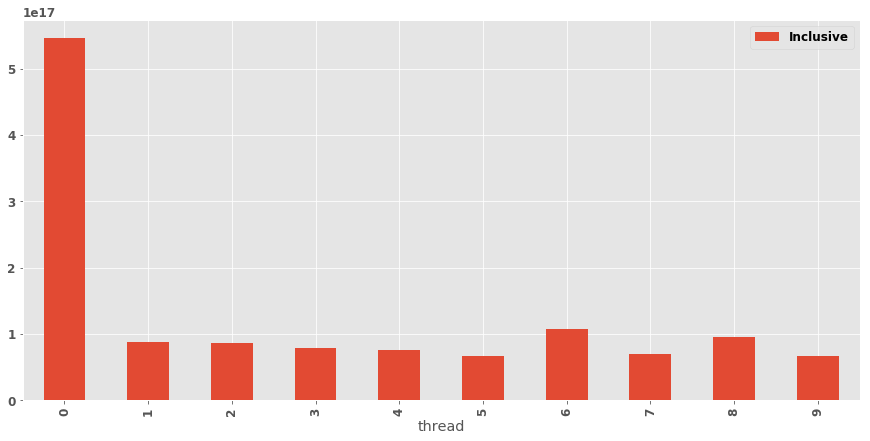

In [14]:
cycles_var = thread_variance(expr_intervals['PAPI_TOT_CYC'],inclusive=True,sort=False,plot=True)
print(cycles_var.head(10))

## 2. Single function details

We can also focus on a specific function and explore its performance. First, let's look at a single metric, total cycles again. Suppose we want to only see the data for function `MkFinder::SelectHitIndices`. Multiple functions can be included by separating them with "|", e.g., `MkFinder::SelectHitIndices|MatriplexSym`.

In [15]:
all_cycles = expr_intervals['PAPI_TOT_CYC']
all_cycles[all_cycles.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")]

Calls  \
rank context thread region                                                      
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     50   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     41   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     33   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     39   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     35   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     33   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     43   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     35   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     45   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     33   

                                                                        Subcalls  \
rank context thread region                                                         
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   

                                                                         Exclusive  \
rank context thread region                                                           
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2416012201   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1637751035   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1404868079   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1632943294   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1388499936   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1212025418   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1827178243   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1361287994   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1743074534   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1282037677   

                                                                         Inclusive  \
rank context thread region                                                           
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2416012201   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1637751035   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1404868079   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1632943294   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1388499936   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1212025418   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1827178243   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1361287994   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1743074534   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1282037677   

                        

## 3. Adding derived metrics

Next, let us explore this function's performance using some derived metrics. These are defined in metrics.py; new metrics can be added there or in the notebook (initially it's easier to add to the notebook).

In [16]:
add_IPC(expr_intervals)
ipc = expr_intervals['DERIVED_IPC']
ipc_fun = ipc[ipc.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")]
ipc_fun.head(100)

Calls  \
context thread region                                                         
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 9.600e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.049e+00   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.103e+00   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.200e+00   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.182e+00   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 9.302e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 8.000e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 7.778e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   

                                                                   Exclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.745e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.163e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.120e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.442e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.923e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.020e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.676e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.584e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.267e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.905e-01   

                                                                   Inclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.745e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.163e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.120e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.442e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  4.923e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.020e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.676e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.584e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.267e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.905e-01   

                                                                   ProfileCalls  \
context thread region                                                             
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   

                                                                   Subcalls  
context thread region                                                        
0       0      [SUMMARY] MkFinder::SelectHitIn

Next, we compute a similar metric, but for vector instructions only, and only packed SIMD vector instructions. Below is Intel's description of the SCALAR_SIMD and PACKED_SIMD counters.
```
 UOPS_RETIRED                                                                 |
|     :SCALAR_SIMD                                                             |
|            Counts the number of scalar SSE, AVX, AVX2, AVX-512 micro-ops reti|
|            red. More specifically, it counts scalar SSE, AVX, AVX2, AVX-512 m|
|            icro-ops except for loads (memory-to-register mov-type micro ops),|
|             division, sqrt.                                                  |
|     :PACKED_SIMD                                                             |
|            Counts the number of vector SSE, AVX, AVX2, AVX-512 micro-ops reti|
|            red. More specifically, it counts packed SSE, AVX, AVX2, AVX-512 m|
|            icro-ops (both floating point and integer) except for loads (memor|
|            y-to-register mov-type micro-ops), packed byte and word multiplies|
|            .                                                                 |
```

In [17]:
add_VIPC(expr_intervals)
vipc = expr_intervals['DERIVED_VIPC']
vipc_fun = vipc.loc[vipc.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")].copy()
vipc_fun.head(10)

Calls  \
context thread region                                                         
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 9.200e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.121e+00   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.154e+00   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.029e+00   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 9.302e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.171e+00   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.133e+00   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.364e+00   

                                                                   Exclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.857e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.616e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.399e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.622e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.415e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.429e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.513e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.676e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.413e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.604e-01   

                                                                   Inclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.857e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.616e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.399e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.622e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.415e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.429e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.513e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.676e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.413e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.604e-01   

                                                                   ProfileCalls  \
context thread region                                                             
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   

                                                                   Subcalls  
context thread region                                                        
0       0      [SUMMARY] MkFinder::SelectHitIn

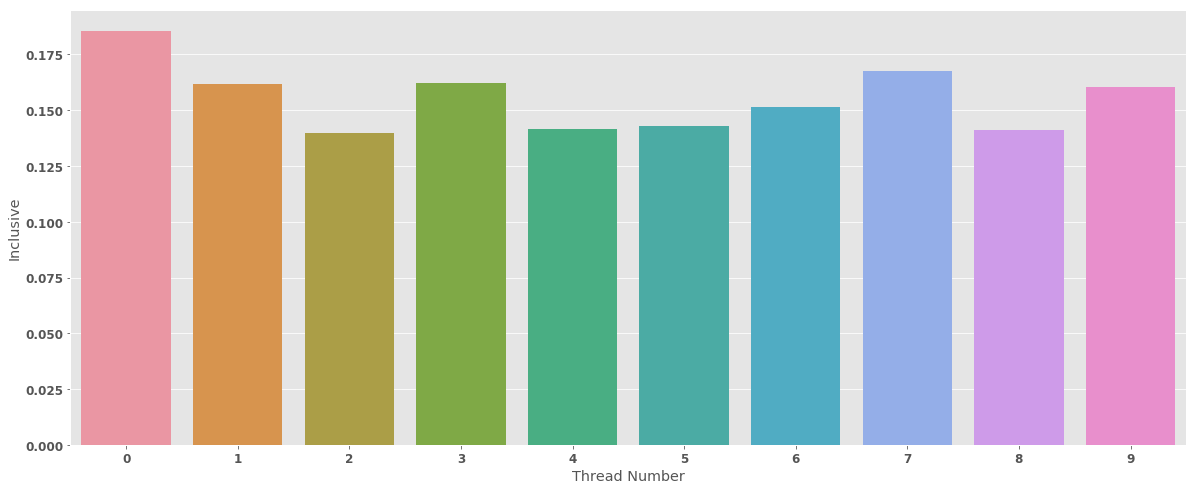

In [18]:
vipc_fun['Thread Number'] = vipc_fun.index.get_level_values('thread')
vipc_fun.head(10)
g = sns.barplot(x='Thread Number',y='Inclusive',data=vipc_fun)

The same can be accomplished by using the ``plot_metric`` function implemented in metrics.py. An example invocation is shown below. The function returns two values, the resulting (copied) dataframe containing only data for the specified function and the handle to the generated Seaborn plot (for further formatting). If no function is specified, the data for all functions is shown per thread.

context  thread  region                                                        
0        0       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.430e-02
         1       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.718e-02
         2       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.338e-02
         3       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    2.018e-02
         4       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.440e-02
         5       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.875e-02
         6       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    3.453e-02
         7       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.240e-02
         8       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    2.215e-02
         9       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.492e-02


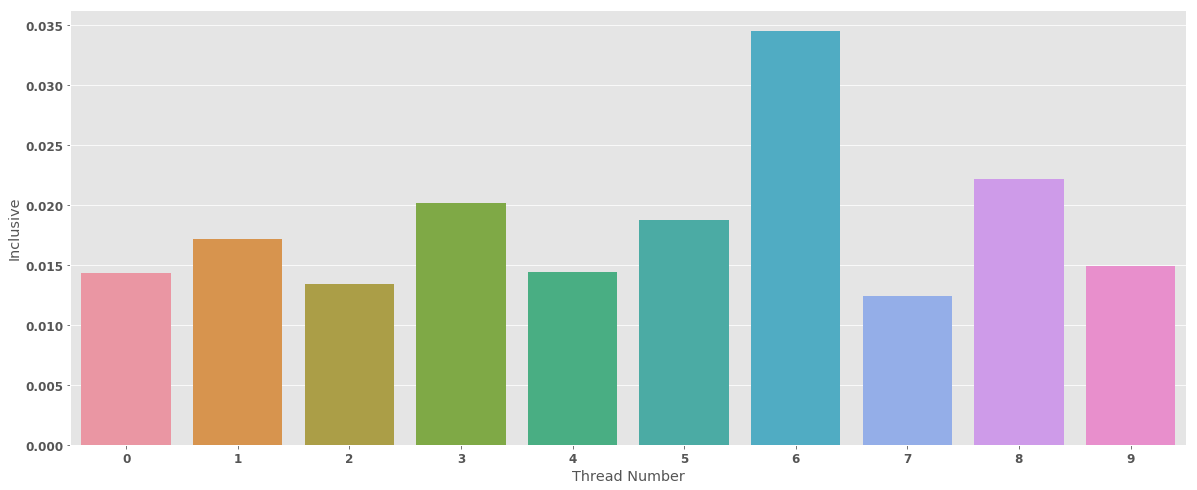

In [19]:
add_L1_missrate(expr_intervals)   # DERIVED_L1_MISSRATE
L1mr_fun, g = plot_metric(expr_intervals,'DERIVED_L1_MISSRATE',function="MkFinder::SelectHitIndices",percent=True)
L1mr_fun['Inclusive'].head(10)

## 4. Explaining performance observations

Next, we compute pairwise correlations between all metrics by combining them into a single dataframe first, and then using the Pandas corr() function. This functionality is also in metrics.py, available through the compute_correlations functions (e.g., `compute_correlations(expr_intervals,'Inclusive',highlight_threshold=0.5)`, the last two arguments are optional, defaults were used in this call). For identical functionality, the lines below can be replaced with just `compute_correlations(expr_intervals,highlight_threshold=0.8)`.

In [50]:
alldata = combine_metrics(expr_intervals,'Inclusive')
cm = sns.light_palette("yellow", as_cmap=True)
correlations_pearson = alldata.corr('pearson').fillna(0)    # Other methods: 'kendall', 'spearman'
correlations_pearson.style.format("{:.2%}").background_gradient(cmap=cm)

,PAPI_TOT_CYC,PAPI_BR_INS,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,PAPI_L2_TCA,PAPI_NATIVE_LLC_MISSES,DERIVED_IPC,DERIVED_VIPC,DERIVED_L1_MISSRATE,PAPI_RES_STL,PAPI_L2_TCM,PAPI_TOT_INS,PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,PAPI_LST_INS,PAPI_BR_CN,PAPI_BR_UCN,PAPI_L1_TCM,PAPI_BR_MSP,PAPI_NATIVE_LLC_REFERENCES
PAPI_TOT_CYC,100.00%,85.42%,63.94%,90.23%,85.68%,0.00%,0.00%,0.00%,62.73%,85.19%,93.93%,81.12%,94.18%,85.80%,74.47%,89.08%,92.36%,91.55%
PAPI_BR_INS,85.42%,100.00%,78.79%,66.05%,60.22%,0.00%,0.00%,0.00%,82.08%,57.65%,89.47%,49.57%,86.47%,97.10%,83.23%,78.84%,95.34%,69.03%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,63.94%,78.79%,100.00%,49.70%,30.62%,0.00%,0.00%,0.00%,37.44%,31.27%,65.58%,35.02%,63.54%,83.58%,37.06%,41.37%,71.07%,50.64%
PAPI_L2_TCA,90.23%,66.05%,49.70%,100.00%,86.98%,0.00%,0.00%,0.00%,40.25%,88.21%,84.92%,87.04%,85.28%,67.31%,56.00%,80.52%,78.07%,92.80%
PAPI_NATIVE_LLC_MISSES,85.68%,60.22%,30.62%,86.98%,100.00%,0.00%,0.00%,0.00%,47.29%,92.55%,80.64%,87.67%,82.37%,60.26%,63.02%,81.56%,74.40%,87.27%
DERIVED_IPC,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
DERIVED_VIPC,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
DERIVED_L1_MISSRATE,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PAPI_RES_STL,62.73%,82.08%,37.44%,40.25%,47.29%,0.00%,0.00%,0.00%,100.00%,40.83%,71.33%,24.12%,66.55%,75.37%,94.69%,73.60%,78.86%,43.85%
PAPI_L2_TCM,85.19%,57.65%,31.27%,88.21%,92.55%,0.00%,0.00%,0.00%,40.83%,100.00%,80.71%,89.42%,82.62%,58.21%,57.98%,81.34%,72.15%,89.62%


In [21]:
correlations_spearman = alldata.corr('spearman')
correlations_spearman.style.format("{:.2%}").background_gradient(cmap=cm)

,PAPI_TOT_CYC,PAPI_BR_INS,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,PAPI_L2_TCA,PAPI_NATIVE_LLC_MISSES,DERIVED_IPC,DERIVED_VIPC,DERIVED_L1_MISSRATE,PAPI_RES_STL,PAPI_L2_TCM,PAPI_TOT_INS,PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,PAPI_LST_INS,PAPI_BR_CN,PAPI_BR_UCN,PAPI_L1_TCM,PAPI_BR_MSP,PAPI_NATIVE_LLC_REFERENCES
PAPI_TOT_CYC,100.00%,70.95%,60.33%,74.78%,72.58%,nan%,nan%,nan%,67.55%,73.18%,71.32%,66.83%,71.48%,70.02%,74.56%,72.65%,78.07%,74.45%
PAPI_BR_INS,70.95%,100.00%,55.96%,67.85%,69.02%,nan%,nan%,nan%,73.56%,69.20%,73.51%,57.33%,72.42%,76.09%,73.81%,69.30%,74.31%,67.31%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,60.33%,55.96%,100.00%,59.23%,56.11%,nan%,nan%,nan%,52.27%,61.42%,61.42%,61.63%,58.88%,58.42%,55.90%,56.05%,60.41%,56.76%
PAPI_L2_TCA,74.78%,67.85%,59.23%,100.00%,74.48%,nan%,nan%,nan%,63.46%,75.57%,71.94%,67.78%,71.49%,66.63%,69.55%,72.57%,72.29%,76.18%
PAPI_NATIVE_LLC_MISSES,72.58%,69.02%,56.11%,74.48%,100.00%,nan%,nan%,nan%,66.12%,76.73%,71.16%,66.42%,70.52%,70.53%,70.48%,74.87%,72.29%,72.26%
DERIVED_IPC,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
DERIVED_VIPC,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
DERIVED_L1_MISSRATE,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
PAPI_RES_STL,67.55%,73.56%,52.27%,63.46%,66.12%,nan%,nan%,nan%,100.00%,66.57%,68.11%,54.25%,69.85%,74.12%,72.00%,62.57%,72.11%,61.00%
PAPI_L2_TCM,73.18%,69.20%,61.42%,75.57%,76.73%,nan%,nan%,nan%,66.57%,100.00%,75.13%,70.23%,73.01%,68.28%,71.44%,76.00%,74.55%,75.05%


As a first step to identifying potential performance degradation causes, we focus on resource stalls. Looking at positive correlations of over 80%, the largest Pearson correlation is with unconditional branches (PAPI_BR_UCN); the lower Spearman value indicates that the linear correlation is larger than the rank correlation with stalls. Among the various memory-related metrics we have available, L1 misses, LLC (last level cache) references, load/store instructions (PAPI_LST_INS) and L2 total accesses (PAPI_L2_TCA) are most correlated with total resource stall cycles. This considers the entire application, and hence does not reveal a particular weakness in a specific code region. 

In [22]:
stalls_pearson = correlations_pearson['PAPI_RES_STL'].to_frame()    #.sort_values(by='PAPI_RES_STL',ascending=False)
stalls_spearman = correlations_spearman['PAPI_RES_STL'].to_frame()    #.sort_values(by='PAPI_RES_STL',ascending=False)
for x in [stalls_pearson, stalls_spearman]: 
    x.index.names = ['counter']
ps_comp =  pd.concat([stalls_pearson.reset_index(drop=0).add_suffix('_pearson'),
                stalls_spearman.reset_index(drop=0).add_suffix('_spearman')], axis=1).fillna(0)
cm2 = sns.diverging_palette(240, 10, n=9, as_cmap=True)
ps_comp.style.format({'PAPI_RES_STL_pearson':"{:.2%}",'PAPI_RES_STL_spearman':"{:.2%}"}).background_gradient(cmap=cm2)

,counter_pearson,PAPI_RES_STL_pearson,counter_spearman,PAPI_RES_STL_spearman
0,PAPI_TOT_CYC,62.73%,PAPI_TOT_CYC,67.55%
1,PAPI_BR_INS,82.08%,PAPI_BR_INS,73.56%
2,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,37.44%,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,52.27%
3,PAPI_L2_TCA,40.25%,PAPI_L2_TCA,63.46%
4,PAPI_NATIVE_LLC_MISSES,47.29%,PAPI_NATIVE_LLC_MISSES,66.12%
5,DERIVED_IPC,0.00%,DERIVED_IPC,0.00%
6,DERIVED_VIPC,0.00%,DERIVED_VIPC,0.00%
7,DERIVED_L1_MISSRATE,0.00%,DERIVED_L1_MISSRATE,0.00%
8,PAPI_RES_STL,100.00%,PAPI_RES_STL,100.00%
9,PAPI_L2_TCM,40.83%,PAPI_L2_TCM,66.57%


Let us do the exact same analysis for our single function of interest, `MkFinder::SelectHitIndices`:

In [23]:
alldata = combine_metrics(expr_intervals,'Inclusive')
alldata_fun = alldata.loc[alldata.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")].copy()
alldata_fun.head(5)

PAPI_TOT_CYC  \
rank context thread region                                                             
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    2416012201   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1637751035   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1404868079   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1632943294   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1388499936   

                                                                        PAPI_BR_INS  \
rank context thread region                                                            
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1.503e+08   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    4.725e+07   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    5.946e+07   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    4.947e+07   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    5.931e+07   

                                                                        PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD  \
rank context thread region                                                                                     
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...                             2.734e+07   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...                             1.046e+07   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...                             1.159e+07   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...                             1.438e+07   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...                             1.447e+07   

                                                                        PAPI_L2_TCA  \
rank context thread region                                                            
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    2.151e+07   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1.563e+07   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    2.210e+07   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    2.645e+07   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...    1.411e+07   

                                                                        PAPI_NATIVE_LLC_MISSES  \
rank context thread region                                                                       
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...               4.425e+06   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...               2.464e+06   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...               2.154e+06   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...               1.851e+06   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...               2.757e+06   

                                                                        DERIVED_IPC  \
rank context thread region                                                            
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...          nan   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...          nan   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...          nan   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...          nan   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...          nan   

                                                                        DERIVED_VIPC  \
rank context thread region                                       

In [24]:
correlations_fun = alldata_fun.corr()
correlations_fun.style.format("{:.2%}").apply(
    lambda x: ["background: yellow" if v > 0.7 else "" for v in x], axis = 1).apply(
    lambda x: ["color: red" if v <0 else "" for v in x], axis = 1)

,PAPI_TOT_CYC,PAPI_BR_INS,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,PAPI_L2_TCA,PAPI_NATIVE_LLC_MISSES,DERIVED_IPC,DERIVED_VIPC,DERIVED_L1_MISSRATE,PAPI_RES_STL,PAPI_L2_TCM,PAPI_TOT_INS,PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,PAPI_LST_INS,PAPI_BR_CN,PAPI_BR_UCN,PAPI_L1_TCM,PAPI_BR_MSP,PAPI_NATIVE_LLC_REFERENCES
PAPI_TOT_CYC,100.00%,79.71%,76.43%,38.82%,61.74%,nan%,nan%,nan%,77.89%,63.64%,84.85%,96.31%,40.37%,79.17%,79.39%,81.91%,70.48%,37.02%
PAPI_BR_INS,79.71%,100.00%,94.75%,24.50%,76.12%,nan%,nan%,nan%,96.12%,84.73%,83.50%,86.83%,67.99%,88.05%,92.42%,66.29%,76.39%,71.56%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,76.43%,94.75%,100.00%,37.53%,76.13%,nan%,nan%,nan%,91.78%,82.09%,90.64%,83.03%,59.22%,84.02%,92.27%,71.64%,66.23%,59.74%
PAPI_L2_TCA,38.82%,24.50%,37.53%,100.00%,-8.54%,nan%,nan%,nan%,23.92%,-4.39%,43.43%,34.09%,-13.94%,5.11%,14.42%,45.27%,8.23%,4.34%
PAPI_NATIVE_LLC_MISSES,61.74%,76.12%,76.13%,-8.54%,100.00%,nan%,nan%,nan%,81.45%,64.73%,70.50%,64.10%,44.99%,77.78%,86.22%,39.20%,62.83%,43.88%
DERIVED_IPC,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
DERIVED_VIPC,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
DERIVED_L1_MISSRATE,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
PAPI_RES_STL,77.89%,96.12%,91.78%,23.92%,81.45%,nan%,nan%,nan%,100.00%,83.84%,87.11%,85.42%,70.80%,87.60%,95.68%,58.37%,83.02%,56.63%
PAPI_L2_TCM,63.64%,84.73%,82.09%,-4.39%,64.73%,nan%,nan%,nan%,83.84%,100.00%,78.53%,75.58%,88.63%,84.64%,89.22%,60.85%,77.13%,50.00%


In [25]:
stalls_fun = correlations_fun['PAPI_RES_STL'].to_frame().sort_values(by='PAPI_RES_STL',ascending=False)
stalls_fun.style.format("{:.2%}").apply(lambda x: ["color: blue" if v > 0.8 else "" for v in x], axis = 1)

,PAPI_RES_STL
PAPI_RES_STL,100.00%
PAPI_BR_INS,96.12%
PAPI_BR_UCN,95.68%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,91.78%
PAPI_BR_CN,87.60%
PAPI_TOT_INS,87.11%
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,85.42%
PAPI_L2_TCM,83.84%
PAPI_BR_MSP,83.02%
PAPI_NATIVE_LLC_MISSES,81.45%


This shows that, among the measurements we have so far, the total number of L1 misses and the vector SIMD operations (note that those include memory operations, not just FLOPs), and the last level cache references are highly correlated with resource stalls. We need to be aware that there may be other major contributors to resource stalls (e.g., mispredicted branches), which we have not yet meaasured, so have not been included in this analysis.

***

### Appendix A: Defining additional custom metrics

The gen_metric method generates the boring bits of the metric adding function. This is being reworked into a much simpler interface, without the need to copy/paste/modify code, but as a temporary method, this serves the purpose.
* List the metrics you will use
* provide a name for the new metric
* paste into metrics.py
* implement the math bit

In [26]:
print(gen_metric(['PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD', 'PAPI_L1_TCM', "MORE"], "VECTOR_PER_MISS"))

def add_VECTOR_PER_MISS(metrics):
	if (not metrics.has_key(PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a0 = metrics[PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD].copy()
	a0.index = a0.index.droplevel()
	u0 = a0.unstack()
	if (not metrics.has_key(PAPI_L1_TCM)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a1 = metrics[PAPI_L1_TCM].copy()
	a1.index = a1.index.droplevel()
	u1 = a1.unstack()
	if (not metrics.has_key(MORE)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a2 = metrics[MORE].copy()
	a2.index = a2.index.droplevel()
	u2 = a2.unstack()
	metrics[VECTOR_PER_MISS] = "PLEASE IMPLEMENT THIS PART"

	return True





## Interesting bits

This is where the stuff is actually calculated.

In [27]:
# levels: 0=trial, 1=node, 2=context, 3=thread, 4=region name -- deprecated
# levels: 0=rank, 1=context, 2=thread, 3=region name -- deprecated

       
n=10

def get_hotspots(metric):
    print('selected metric: %s\n' %metric)
    hotspots(expr_intervals[metric], n, 1)

    print('='*80)

    filtered_dfs = filter_libs_out(expr_intervals[metric])
    hotspots(filtered_dfs, n, 1)
    
get_hotspots('PAPI_TOT_CYC')



selected metric: PAPI_TOT_CYC

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (4590945438)
2: [SUMMARY] _int_free  (2578157027)
3: [SUMMARY] _int_malloc  (2493065090)
4: [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)  (2416012201)
5: [SUMMARY] __svml_sincosf8_l9  (2132547303)
6: [SUMMARY] __GI___libc_malloc  (2073114673)
7: [SUMMARY] __intel_mic_avx512f_memset  (1441617163)
8: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20 (1396141344)
9: [SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)  (1051668071)
10: [SUMMARY] __GI___sched_yield  (951316750)
Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (4590945438)
2: [SUMMARY] _int_free  (2578157027)
3: [SUMMARY] _int_malloc  (2493065090)
4: [SUMMARY] MkFinder::SelectHit

In [28]:
add_L1_missrate(expr_intervals)
get_hotspots('DERIVED_L1_MISSRATE')

selected metric: DERIVED_L1_MISSRATE

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] ROOT::Math::MatRepSym<float, 6u>::operator=(ROOT::Math::MatRepSym<float, 6u> const&)  (1.8550557189979495)
2: [SUMMARY] _ZN9__gnu_cxx13new_allocatorIN8MkFinder11IdxChi2ListEE9constructIS2_IRKS2_EEEvPT_DpOT0_  (0.7466136233758893)
3: [SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)  (0.5062736265886603)
4: [SUMMARY] Track::addHitIdx(int, int, float)  (0.4976990205672784)
5: [SUMMARY] (anonymous namespace)::Chi2Similarity(Matriplex::Matriplex<float, 2, 1, 8> const&, Matriplex::MatriplexSym<float, 2, 8> const&, Matriplex::Matriplex<float, 1, 1, 8>&)  (0.32558552354391723)
6: [SUMMARY] __svml_logf8_l9  (0.265742414404296)
7: [SUMMARY] __svml_atan2f8_l9  (0.19623

In [29]:
get_hotspots('PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD')

selected metric: PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (346302272)
2: [SUMMARY] __GI___libc_malloc  (52501729)
3: [SUMMARY] _int_malloc  (44218112)
4: [SUMMARY] __libm_sse2_sincosf  (38832017)
5: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20 (32300611)
6: [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)  (27336867)
7: [SUMMARY] __svml_sincosf8_l9  (19736668)
8: [SUMMARY] Track::zAtR(float, float*) const  (14946345)
9: [SUMMARY] __libm_tanf_l9  (14713266)
10: [SUMMARY] __intel_mic_avx512f_memset  (10725916)
Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (346302272)
2: [SUMMARY] __GI___libc_malloc  (52501729)
3: [SUMMARY] _int_malloc  (44218112)
4: [SUMMARY] __libm_sse2_sincosf  (38832017)
5: [SUMMARY] UNRESOLVED /storage/pack